<a href="https://colab.research.google.com/github/merttezcan/Bitcoin-Price-Prediction-using-LSTM/blob/main/dl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
#getting the data

data = pd.read_csv('BTC-USD.csv', date_parser = True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2802,2022-05-20,30311.119141,30664.976563,28793.605469,29200.740234,29200.740234,30749382605
2803,2022-05-21,29199.859375,29588.869141,29027.394531,29432.226563,29432.226563,17274840442
2804,2022-05-22,29432.472656,30425.861328,29275.183594,30323.722656,30323.722656,21631532270
2805,2022-05-23,30309.396484,30590.585938,28975.560547,29098.910156,29098.910156,31483454557
2806,2022-05-24,29083.347656,29397.148438,29083.347656,29282.056641,29282.056641,31013728256


In [ ]:
#splitting the data into training and test sets

raw_training_data = data[data['Date']< '2020-01-01'].copy()
raw_test_data = data[data['Date']> '2020-01-01'].copy()

training_data = raw_training_data.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,465.864014,468.174011,452.421997,457.334015,21056800
1,456.859985,456.859985,413.104004,424.440002,34483200
2,424.102997,427.834991,384.532013,394.795990,37919700
3,394.673004,423.295990,389.882996,408.903992,36863600
4,408.084991,412.425995,393.181000,398.821014,26580100


In [ ]:
#applying minmax scaler, it preserves the shape, so we can unscale it at the end and check the prices

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[1.49732345e-02, 1.29013200e-02, 1.49400698e-02, 1.44534769e-02,
        3.35749244e-04],
       [1.45066780e-02, 1.23321258e-02, 1.28489753e-02, 1.27508263e-02,
        6.33453324e-04],
       [1.28093283e-02, 1.08719155e-02, 1.13293978e-02, 1.12164013e-02,
        7.09650970e-04],
       ...,
       [3.70008086e-01, 3.67365217e-01, 3.78051927e-01, 3.74990337e-01,
        4.97548412e-01],
       [3.75325771e-01, 3.64390763e-01, 3.77862744e-01, 3.68279031e-01,
        5.07057851e-01],
       [3.68805505e-01, 3.58377151e-01, 3.72197021e-01, 3.63134123e-01,
        4.69226533e-01]])

In [ ]:
#creating X_train and Y_train

X_train = [] 
Y_train = []

In [ ]:
#checking the shape of the training data

training_data.shape[0]

1932

In [ ]:
#generating sequences for LSTM

for i in range(100, training_data.shape[0]):
  X_train.append(training_data[i-100:i])
  Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(1832, 100, 5)

In [ ]:
#creating the LSTM model with one dropout and one dense layer

model = Sequential()
model.add(LSTM(units = 100, activation = 'relu', input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 50, validation_split = 0.1)

Epoch 1/20
33/33 [==============================] - 7s 160ms/step - loss: 0.0154 - val_loss: 0.0013
Epoch 2/20
33/33 [==============================] - 5s 152ms/step - loss: 0.0040 - val_loss: 8.0410e-04
Epoch 3/20
33/33 [==============================] - 5s 147ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 4/20
33/33 [==============================] - 5s 149ms/step - loss: 0.0034 - val_loss: 7.9477e-04
Epoch 5/20
33/33 [==============================] - 5s 147ms/step - loss: 0.0031 - val_loss: 5.6430e-04
Epoch 6/20
33/33 [==============================] - 5s 144ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 7/20
33/33 [==============================] - 5s 152ms/step - loss: 0.0024 - val_loss: 8.0681e-04
Epoch 8/20
33/33 [==============================] - 5s 149ms/step - loss: 0.0031 - val_loss: 5.9148e-04
Epoch 9/20
33/33 [==============================] - 5s 149ms/step - loss: 0.0022 - val_loss: 5.2299e-04
Epoch 10/20
33/33 [==============================] - 6s 189ms/step - loss: 0

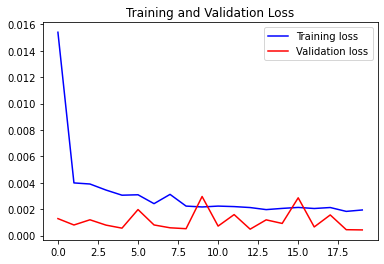

In [ ]:
#analysing the losses

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
#creating a test dataset using the data of last 100 days

seq_60_days = raw_training_data.tail(100)
df= seq_60_days.append(raw_test_data, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df

,Open,High,Low,Close,Volume
0,10067.962891,10074.238281,9727.143555,9729.324219,15144925408
1,9729.321289,9804.317383,8370.801758,8620.566406,25002886689
2,8603.428711,8744.828125,8325.396484,8486.993164,21744728353
3,8487.669922,8515.685547,7895.629395,8118.967773,19258205289
4,8113.101074,8271.520508,7965.922852,8251.845703,16408941156
...,...,...,...,...,...
969,30311.119141,30664.976563,28793.605469,29200.740234,30749382605
970,29199.859375,29588.869141,29027.394531,29432.226563,17274840442
971,29432.472656,30425.861328,29275.183594,30323.722656,21631532270
972,30309.396484,30590.585938,28975.560547,29098.910156,31483454557


In [ ]:
#scaling the test dataset

inputs = scaler.transform(df)
inputs

array([[0.51251957, 0.49617014, 0.50820838, 0.49438761, 0.33567787],
       [0.49497238, 0.48259076, 0.43607247, 0.4369964 , 0.55425882],
       [0.43663266, 0.42928921, 0.43365763, 0.43008242, 0.48201555],
       ...,
       [1.51591904, 1.52003428, 1.54785453, 1.56038903, 0.47950565],
       [1.56135809, 1.52832137, 1.53191933, 1.49699063, 0.6979527 ],
       [1.49782863, 1.46828105, 1.5376519 , 1.50647061, 0.68753744]])

In [ ]:
#generating sequences for test dataset

X_test = []
Y_test = []

for i in range (100, inputs.shape[0]):
  X_test.append(inputs[i-100:i])
  Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape
Y_pred = model.predict(X_test)
Y_pred, Y_test

(array([[0.37397423],
        [0.37026903],
        [0.37182587],
        [0.37049377],
        [0.3719756 ],
        [0.37701374],
        [0.38886175],
        [0.4017167 ],
        [0.40465546],
        [0.40928015],
        [0.4123023 ],
        [0.4128116 ],
        [0.41366085],
        [0.43059003],
        [0.44236523],
        [0.44497195],
        [0.45065707],
        [0.45318723],
        [0.45491895],
        [0.44872072],
        [0.4431158 ],
        [0.43896812],
        [0.43564415],
        [0.43081316],
        [0.4248365 ],
        [0.4235205 ],
        [0.43062115],
        [0.4441002 ],
        [0.45518354],
        [0.46550396],
        [0.47140834],
        [0.47330728],
        [0.47719356],
        [0.47928426],
        [0.4779518 ],
        [0.48147866],
        [0.48831415],
        [0.49235806],
        [0.4960707 ],
        [0.50126094],
        [0.5066889 ],
        [0.50870466],
        [0.5172844 ],
        [0.5259824 ],
        [0.52625793],
        [0

In [ ]:
scaler.scale_

array([5.18164146e-05, 5.03087220e-05, 5.31841635e-05, 5.17617168e-05,
       2.21730382e-11])

In [ ]:
scale = 1/5.18164146e-05

In [ ]:
#unscaling to see the prices in correct way

Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [ ]:
Y_pred

array([[ 7217.293 ],
       [ 7145.7866],
       [ 7175.832 ],
       [ 7150.124 ],
       [ 7178.7217],
       [ 7275.952 ],
       [ 7504.6055],
       [ 7752.6924],
       [ 7809.4067],
       [ 7898.6587],
       [ 7956.9824],
       [ 7966.8115],
       [ 7983.201 ],
       [ 8309.916 ],
       [ 8537.164 ],
       [ 8587.471 ],
       [ 8697.1875],
       [ 8746.017 ],
       [ 8779.4375],
       [ 8659.818 ],
       [ 8551.649 ],
       [ 8471.604 ],
       [ 8407.455 ],
       [ 8314.222 ],
       [ 8198.879 ],
       [ 8173.482 ],
       [ 8310.517 ],
       [ 8570.647 ],
       [ 8784.544 ],
       [ 8983.717 ],
       [ 9097.664 ],
       [ 9134.312 ],
       [ 9209.3125],
       [ 9249.661 ],
       [ 9223.946 ],
       [ 9292.011 ],
       [ 9423.928 ],
       [ 9501.971 ],
       [ 9573.621 ],
       [ 9673.787 ],
       [ 9778.54  ],
       [ 9817.442 ],
       [ 9983.022 ],
       [10150.884 ],
       [10156.201 ],
       [10124.556 ],
       [10019.22  ],
       [ 9930

In [ ]:
Y_test

array([ 7025.65427061,  6807.5317115 ,  7168.47848868,  7233.55466072,
        7233.55514872,  7591.7851299 ,  7985.0385481 ,  7905.39889906,
        7701.41061796,  7985.2939191 ,  7856.36472004,  8012.87497412,
        7964.03610609,  8648.44675144,  8635.58444644,  8548.31296239,
        8750.31491549,  8764.5483145 ,  8527.73483738,  8482.09421236,
        8567.3139394 ,  8503.75339237,  8228.67038423,  8263.22214224,
        8187.51315721,  8420.41159533,  8735.62741549,  9180.57370472,
        9139.11960369,  9331.41647879,  9169.46042371,  9212.92331473,
        9167.78659571,  9115.94479868,  9006.51901763,  9440.92429085,
        9549.1059319 ,  9616.17331494,  9686.99753298,  9938.6625721 ,
        9678.99460397, 10025.49069715, 10147.06394021, 10034.65378315,
       10136.95944721,  9712.28268999,  9759.66354901,  9514.33347089,
        9966.90183012,  9452.42819686,  9434.88522885,  9510.81003289,
        9486.42136087,  9744.68601001,  9474.41550187,  9161.39304071,
      

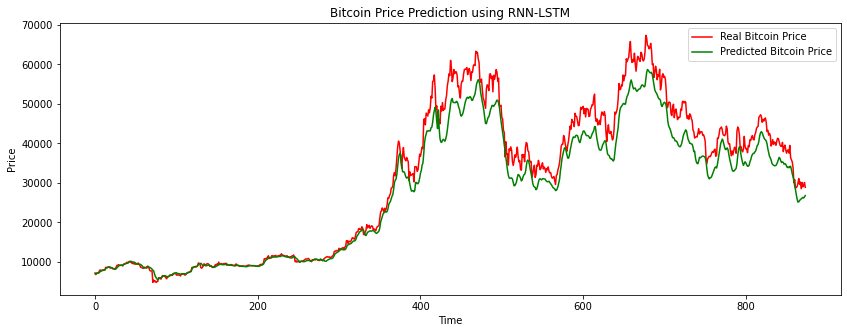

In [ ]:
#final plot

plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()